In [1]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torchvision import transforms as T
from dataloader.chexpert import ChexpertDataset
import numpy as np
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
import cv2
from PIL import Image
tensor2pli = T.ToPILImage()
pli2tensor = T.ToTensor()
cuda = True

In [2]:
#!scp -P 22 -i ~/.ssh/iso_id_rsa -r grafr@131.159.94.16:/space/grafr/*.pth output/

In [3]:
args = type('test', (), {})()


args.deit_tiny_distilled_patch16_224 = False
args.deit_base_distilled_patch16_224 = False
args.densnet_121 = False
args.CoAtNet0 = False
args.CoAtNet1 = False
args.CoAtNet2 = False
args.CoAtNet3 = False
args.CoAtNet4 = False
args.ResNN12 = False
args.NativeResNN12 = False



args.base_ckpt = -1
args.ckpt_path = "C:/Users/rober/Desktop/ios/output"
args.train = False


args.deit_tiny_distilled_patch16_224 = True
args.exp_name = "Vit_on_class"




import training.Loader as Loader
model = Loader.getNN(args)
Loader.load(args,model)

Using cache found in C:\Users\rober/.cache\torch\hub\facebookresearch_deit_main


reload last Checkpoint for  deit_16_224


In [4]:
exp_name = "vit"
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
#net = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_distilled_patch16_224', pretrained=True)
#net2 = torch.nn.Linear(1000,14)
    
#net.load_state_dict(torch.load(f'C:/Users/rober/Desktop/ios/output/{exp_name}.pth'),strict=False)
#net2.load_state_dict(torch.load(f'C:/Users/rober/Desktop/ios/output/{exp_name}2.pth'))


#class fuseNetwork(nn.Module):
#    def __init__(self,a,b):
#        super().__init__()
#        self.a = a
#        self.b = b
        
#    def forward(self,x):
#        x = self.a(x)[0]
#        x = self.b(x)
#        return x.unsqueeze(0)
#model = fuseNetwork(net,net2)

image_size = 224
patch_size = 14
#image_size = 384
#patch_size = 24
model.eval()
if cuda:
    model = model.cuda()
net = model.a
target_layers = model.a.blocks[-1].norm1


def reshape_transform(tensor, height=patch_size, width=patch_size):
    global num_cls_token
    num_cls_token = tensor.size(1) - height*width
    assert(num_cls_token == 1 or num_cls_token == 2)
    result = tensor[:, num_cls_token:, :].reshape(tensor.size(0),height, width, tensor.size(2))
    #result = tensor[:, 1:, :].reshape(tensor.size(0),height, width, tensor.size(2))
    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [5]:
def get_random_deform_parameter():
        import math
        minpoints = 3
        maxpoints = 18
        points = np.random.randint(maxpoints-minpoints+1)+minpoints
        sigma = np.random.uniform()*(70/(points*4))+2
        points = int(points)
        return (sigma,points)

def deformed_np(X,sigma = None ,points = None):
    X = np.asarray(X)
    #Deform
    if sigma == None:
        sigma, points = get_random_deform_parameter()
    import elasticdeform
    out = elasticdeform.deform_random_grid(np.pad(np.float32(X[...,0]),pad_width=((5,5),(5,5)),mode='reflect'),sigma=sigma, points=points)
    out = np.uint8(out[5:-5,5:-5])
    out[out<0]=0
    out[out>255]=255
    return Image.fromarray(np.stack((out,out,out),axis=2))



In [6]:

transforms = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
        ]) 
transforms2 = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        ]) 

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unorm = UnNormalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)    
trainset = ChexpertDataset(root="C:/Users/rober/Documents/",cache_dir = None,version="small" ,transforms=transforms)

categories = trainset.data.labels
index = 1

Load the training dataframe into memory.


(224, 224, 3) tensor([0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.])


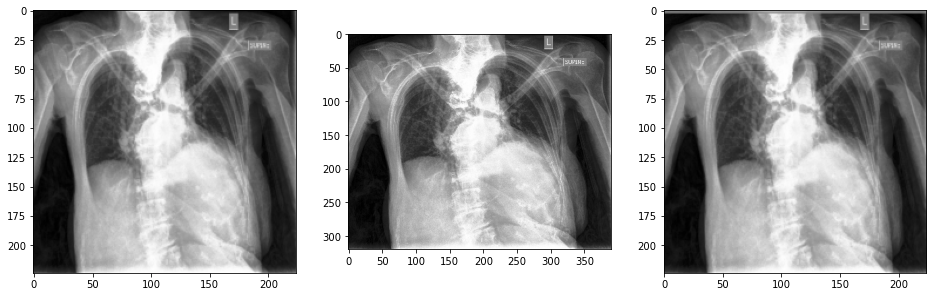

<Figure size 432x288 with 0 Axes>

In [7]:

x = trainset[index]
input_tensor = x[0]

gt = x[1]
#in2 = x[2]
if cuda:
    input_tensor = input_tensor.cuda()

rgb_img = unorm(input_tensor.detach()).cpu().permute(1,2,0).numpy()
#rgb_img2 = in2
rgb_img /= rgb_img.max()

fig, (ax1, ax2,ax3) = plt.subplots(nrows=1,ncols = 3, figsize=(16, 16))
_ = ax1.imshow(rgb_img)
_ = ax2.imshow(trainset.img)
_ = ax3.imshow(unorm(transforms2(trainset.img).permute(1,2,0)))
   
plt.figure()
if len(input_tensor.shape) == 3:
    input_tensor = torch.unsqueeze(input_tensor, 0)
input_tensor_org = input_tensor

print(rgb_img.shape,gt)
input_tensor_org.shape
index+=1
# Note: input_tensor can be a batch tensor with several images!

In [8]:
#with torch.no_grad():
    #s = torch.nn.Softmax(dim=1)
    #s = torch.nn.Sigmoid()
    #last_att = []
    #out = s(model(input_tensor))
#Hijack attention
last_att = []
i = len(net.blocks)-1
def makeFun(i):
    def forward_hijack(x):
            self = net.blocks[i].attn
            B, N, C = x.shape
            qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            global last_att
            last_att.append(attn)
            #print(len(last_att), 'attention',i)
            attn = self.attn_drop(attn)

            x = (attn @ v).transpose(1, 2).reshape(B, N, C)
            x = self.proj(x)
            x = self.proj_drop(x)
            return x
    return forward_hijack
for i in range(len(net.blocks)):
    net.blocks[i].attn.forward = makeFun(i)
#with torch.no_grad():
#    assert((out ==s(model(input_tensor))).all())

In [9]:
def attention_vis(logits,att_mat,ramen = 50):
    if len(att_mat)==0:
        return np.ones((rgb_img.shape[0],rgb_img.shape[1]))
    att_mat = torch.stack(att_mat).squeeze(1).cpu()
    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att.cpu()
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]
    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = patch_size #int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, num_cls_token:].reshape(grid_size, grid_size).detach().numpy()
    mask[mask<0] = 0
    mask -= mask.min()
    mask = cv2.resize(mask / mask.max(), (rgb_img.shape[0],rgb_img.shape[1]))[..., np.newaxis]
    if ramen != 0:
        mask[:ramen]=mask.mean()
        mask[-ramen:]=mask.mean()
        mask[:,:ramen]=mask.mean()
        mask[:,-ramen:]=mask.mean()
    mask -= mask.min()
    mask /= mask.max()
    if ramen != 0:
        mask[:ramen]=mask.min()
        mask[-ramen:]=mask.min()
        mask[:,:ramen]=mask.min()
        mask[:,-ramen:]=mask.min()
    return mask
#Source: https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb

In [12]:
model.eval()
#s = torch.nn.Softmax(dim=1)
s = torch.nn.Sigmoid()
last_att = []
with torch.no_grad():
    out = s(model(input_tensor))
cam = GradCAM(model, target_layers, use_cuda=cuda, reshape_transform=reshape_transform)
#Show top categories per image
#for i in range(len(categories)):
#    print(int(out[0,i].item()*10000)/10000,"\t",gt[i].item(),categories[i],)


In [13]:
target_category = torch.argmax(out).item()
#target_category = 7
print(categories[target_category])

No Finding


No Finding -- id: 0 -- 94.47 %


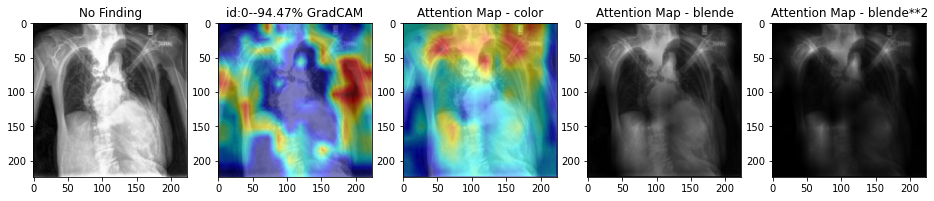

In [14]:
def showClass(cl):
    torch.cuda.empty_cache()
    global last_att
    last_att = []
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, target_category=cl)
    #grayscale_att = last_att[-1][0].permute(1,2,0).detach().cpu()
    
    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = 1-grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam)
    mask = attention_vis(out,last_att,ramen = 1)
    #last_att = last_att[-1]
    visualization2 = show_cam_on_image(rgb_img, 1-mask)
    visualization3 = (mask * rgb_img.astype("float")*255).astype("uint8")
    visualization4 = (mask**2/(mask**2).max() * rgb_img.astype("float")*255).astype("uint8")
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(nrows=1,ncols = 5, figsize=(16, 16))
    print(f"{categories[cl]} -- id: {cl} -- {int(out[0,cl]*10000)/100} %")
    
    result = ((mask**2) * rgb_img*255).astype("uint8")
    imagenet_labels = categories
    ax1.set_title(f"{categories[cl]}")
    ax2.set_title(f'id:{cl}--{int(out[0,cl]*10000)/100}% GradCAM')
    ax3.set_title('Attention Map - color')
    ax4.set_title('Attention Map - blende')
    ax5.set_title('Attention Map - blende**2')
    _ = ax1.imshow(rgb_img)
    _ = ax2.imshow(visualization)
    _ = ax3.imshow(visualization2)
    _ = ax4.imshow(visualization3)
    _ = ax5.imshow(visualization4)
    #_ = ax6.imshow(rgb_img)
    
showClass(target_category)

No Finding -- id: 0 -- 94.47 %


IndexError: index 1 is out of bounds for dimension 1 with size 1

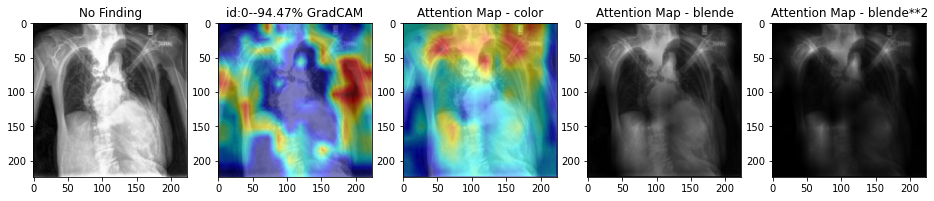

In [15]:
for i in range(len(categories)):
    #print(categories[j],top5_prob[0,i].item(),j)
    showClass(i)